In [1]:
import sklearn
import grakel
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel.utils import graph_from_networkx

In [50]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, GINConv, global_add_pool
from torch_geometric.logging import log
import torch
import torch.nn.functional as F

In [3]:
import networkx as nx
import networkx.algorithms.isomorphism as iso_utils
from networkx import weisfeiler_lehman_graph_hash
import pandas as pd
import numpy as np

In [45]:
import matplotlib.pyplot as plt
import seaborn

In [5]:
consider_node_features = True

In [55]:
def set_seed(seed = 42):
    # Torch RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Python RNG
    np.random.seed(seed)
    random.seed(seed)

In [6]:
def partition_iso(dataset):
    partitions = [] # Found partitions
    for G_idx, G_torch in enumerate(dataset): # Loop over each element
        if consider_node_features:
            G_nx = to_networkx(G_torch, node_attrs=['x'])
        else:
            G_nx = to_networkx(G_torch)
        found = False # Note it is not yet part of a know partition
        for p in partitions:
            nm = None
            if consider_node_features:
                nm = iso_utils.categorical_node_match("x", None)
            if nx.is_isomorphic(G_nx, p[0][1], node_match=nm): # Found a partition for it!
                p.append((G_idx, G_nx))
                found = True
                break
        if not found: # Make a new partition for it.
            partitions.append([(G_idx, G_nx)])
    return partitions

In [7]:
def partition_labels(dataset):
    partitions = [] # Found partitions
    for G_idx, G_torch in enumerate(dataset): # Loop over each element
        G_nx = to_networkx(G_torch)
        found = False # Note it is not yet part of a know partition
        for p in partitions:
            if G_torch.y[0].item() == p[0][1]: # Found a partition for it!
                p.append((G_idx, G_torch.y[0].item()))
                found = True
                break
        if not found: # Make a new partition for it.
            partitions.append([(G_idx, G_torch.y[0].item())])
    return partitions

In [8]:
def partition_hashes(dataset):
    partitions = [] # Found partitions
    for G_idx, G_hash in enumerate(dataset): # Loop over each element
        found = False # Note it is not yet part of a know partition
        for p in partitions:
            if G_hash == p[0][1]: # Found a partition for it!
                p.append((G_idx, G_hash))
                found = True
                break
        if not found: # Make a new partition for it.
            partitions.append([(G_idx, G_hash)])
    return partitions

In [9]:
def partition_graph_sizes(dataset):
    partitions = [] # Found partitions
    for G_idx, G_torch in enumerate(dataset): # Loop over each element
        G_nx = to_networkx(G_torch)
        found = False # Note it is not yet part of a know partition
        for p in partitions:
            if G_nx.number_of_nodes() == p[0][1]: # Found a partition for it!
                p.append((G_idx, G_nx.number_of_nodes()))
                found = True
                break
        if not found: # Make a new partition for it.
            partitions.append([(G_idx, G_nx.number_of_nodes())])
    return partitions

In [10]:
def eq_class_stats(name, partition):
    print('num', name, 'eq classes:', len(partition))
    print('num singleton', name, 'classes:', sum([int(len(c) == 1) for c in partition]))
    return [len(partition), sum([int(len(c) == 1) for c in partition])]

In [11]:
def uncert(U, V, N):
    P_UV = torch.zeros((len(U), len(V)))
    P_U = torch.zeros(len(U))
    P_V = torch.zeros(len(V))
    for U_idx, u in enumerate(U):
        P_U[U_idx] = len(u) / N
        for V_idx, v in enumerate(V):
            P_V[V_idx] = len(v) / N
            for G_u, _ in u:
                for G_v, _ in v:
                    if G_u == G_v:
                        P_UV[U_idx, V_idx] += 1 / N
    
    uncert_UV = torch.sum(P_UV * torch.nan_to_num(torch.log2((P_UV / P_U.reshape(-1, 1)) / P_V))).item()
    H_U = -torch.sum(P_U * torch.nan_to_num(torch.log2(P_U))).item()
    H_V = -torch.sum(P_V * torch.nan_to_num(torch.log2(P_V))).item()
    # return 2 * uncert_UV / (H_U + H_V)
    # given U, what fraction of the bits of V can we predict?
    if H_V == 0:
        return 0
    return uncert_UV / H_V

In [12]:
def const(U, V):
    num_consistent = 0
    for _, u in enumerate(U):
        labels = []
        for G_u, _ in u:
            for _, v in enumerate(V):
                for G_v, label in v:
                    if G_u == G_v:
                        labels.append(label)
        if len(set(labels)) == 1:
            num_consistent += 1
    return num_consistent / len(U)

In [13]:
def acc(U, V):
    num_correct = 0
    total = 0
    for _, u in enumerate(U):
        labels = []
        for G_u, _ in u:
            for _, v in enumerate(V):
                for G_v, label in v:
                    if G_u == G_v:
                        labels.append(label)
        maj_vote = max(set(labels), key = labels.count)
        for l in labels:
            if l == maj_vote:
                num_correct += 1
        total += len(labels)
    return (num_correct / total) * 100

In [14]:
all_datasets = []
for dataset_name in ["MUTAG", "PROTEINS"]:
    all_datasets.append((dataset_name, TUDataset("data", dataset_name)))

In [15]:
pd_basic_stats = {}

for dataset_name, dataset in all_datasets:
    stats = []
    
    print("======", dataset_name, "======")
    stats.append(len(dataset))
    print('total graphs:', stats[-1])
    
    label_eq_classes = partition_labels(dataset)
    stats.extend(eq_class_stats("label", label_eq_classes))
    print()
    
    size_eq_classes = partition_graph_sizes(dataset)
    stats.extend(eq_class_stats("graph size", size_eq_classes))
    print()
    
    stats.append(uncert(size_eq_classes, label_eq_classes, len(dataset)))
    print('uncert of graph size with labels:', stats[-1])
    # print('consistency of graph size with labels:', const(size_eq_classes, label_eq_classes))
    stats.append(acc(size_eq_classes, label_eq_classes))
    print('predictive accuracy of graph size for labels:', stats[-1])
    print()
    
    pd_basic_stats[dataset_name] = stats[:2]

cols = ['# graphs', '# unique labels'] # , '# singleton labels', '# unique graph sizes', '# singleton graph sizes', 'uncert(graph size, labels)', 'acc(graph size, labels)']
pd.DataFrame.from_dict(pd_basic_stats, orient='index', columns=cols)
# pd_basic_stats = pd.DataFrame.from_dict(pd_basic_stats, orient='index', columns=cols)
# print(pd_basic_stats.to_latex())

====== MUTAG ======
total graphs: 188
num label eq classes: 2
num singleton label classes: 0

num graph size eq classes: 19
num singleton graph size classes: 1

uncert of graph size with labels: 0.5338342632791968
predictive accuracy of graph size for labels: 86.17021276595744

====== PROTEINS ======
total graphs: 1113
num label eq classes: 2
num singleton label classes: 0

num graph size eq classes: 149
num singleton graph size classes: 53

uncert of graph size with labels: 0.25855076125285315
predictive accuracy of graph size for labels: 73.22551662174304



,# graphs,# unique labels
MUTAG,188,2
PROTEINS,1113,2


In [16]:
pd_iso_stats = {}

for dataset_name, dataset in all_datasets:
    print("======", dataset_name, "======")
    stats = []

    iso_eq_classes = partition_iso(dataset)
    stats.extend(eq_class_stats("iso", iso_eq_classes))
    print()
    
#     ged_eq_classes = partition_ged(dataset, 3)
#     stats.extend(eq_class_stats("ged", ged_eq_classes))
#     print()

    label_eq_classes = partition_labels(dataset)

    stats.append(uncert(iso_eq_classes, label_eq_classes, len(dataset)))
    print('uncert of iso with labels:', stats[-1])
    # print('consistency of iso with labels:', const(iso_eq_classes, label_eq_classes))
    stats.append(acc(iso_eq_classes, label_eq_classes))
    print('predictive accuracy of iso for labels:', stats[-1])
    print()
    
    pd_iso_stats[dataset_name] = stats

cols = ['# unique iso graphs', '# singleton iso graphs', \
        'uncert(iso, labels)', 'acc(iso, labels)'] 
pd.DataFrame.from_dict(pd_iso_stats, orient='index', columns=cols)
# pd_iso_stats = pd.DataFrame.from_dict(pd_iso_stats, orient='index', columns=cols)
# print(pd_iso_stats.to_latex())

====== MUTAG ======
num iso eq classes: 175
num singleton iso classes: 164

uncert of iso with labels: 1.0
predictive accuracy of iso for labels: 100.0

====== PROTEINS ======
num iso eq classes: 996
num singleton iso classes: 962

uncert of iso with labels: 0.9299793353056682
predictive accuracy of iso for labels: 97.48427672955975



,# unique iso graphs,# singleton iso graphs,"uncert(iso, labels)","acc(iso, labels)"
MUTAG,175,164,1.000000,100.000000
PROTEINS,996,962,0.929979,97.484277


In [17]:
def draw_indist_graphs(wl, iso, dataset):
    for u in wl:
        iso_classes = []
        for G_u, _ in u:
            for idx_v, v in enumerate(iso):
                for G_v, _ in v:
                    if G_u == G_v:
                        iso_classes.append(idx_v)
        drawn_classes = set()
        to_draw = []
        if len(set(iso_classes)) > 1:
            for (G_u, _), iso_class in zip(u, iso_classes):
                if iso_class not in drawn_classes:
                    to_draw.append(to_networkx(dataset[G_u]))
                    drawn_classes.add(iso_class)
                    
        for idx, G_nx in enumerate(to_draw):
            plt.subplot(100 + len(to_draw) * 10 + idx + 1)
            nx.draw(G_nx,font_size=8)
        plt.show()

====== MUTAG ======
num wl-1 eq classes: 90
num singleton wl-1 classes: 53
uncert with iso: 0.8056955972504555
uncert with labels: 0.863840520071749
predictive accuracy for labels: 95.74468085106383

num wl-2 eq classes: 167
num singleton wl-2 classes: 152
uncert with iso: 0.9856400960695396
uncert with labels: 0.9884373074309809
predictive accuracy for labels: 99.46808510638297

num wl-3 eq classes: 171
num singleton wl-3 classes: 158
uncert with iso: 0.99281995148635
uncert with labels: 0.999999935216478
predictive accuracy for labels: 100.0



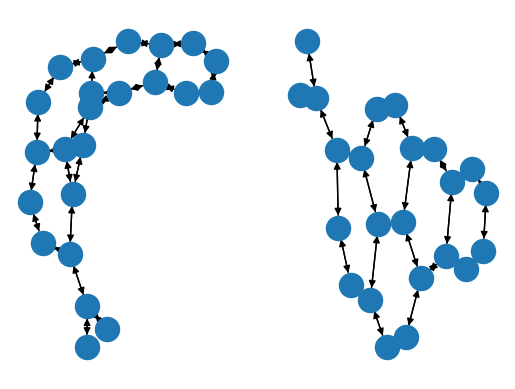

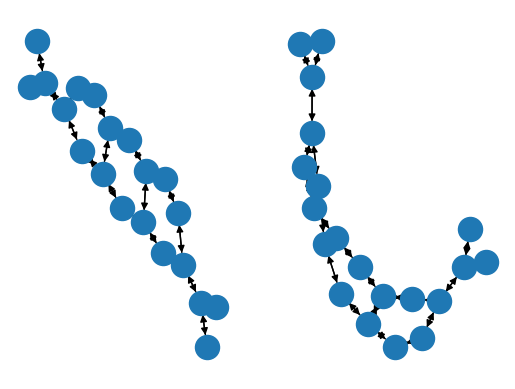

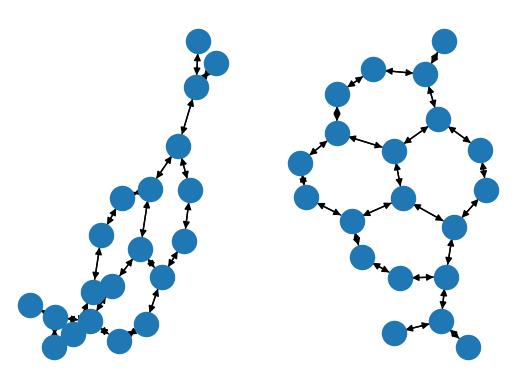

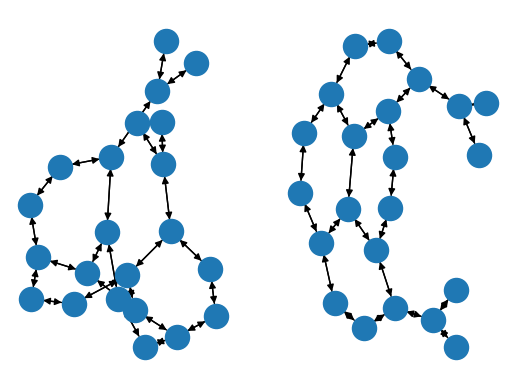


====== PROTEINS ======
num wl-1 eq classes: 929
num singleton wl-1 classes: 850
uncert with iso: 0.9857038202740275
uncert with labels: 0.8762927068104337
predictive accuracy for labels: 95.23809523809523

num wl-2 eq classes: 996
num singleton wl-2 classes: 962
uncert with iso: 0.9999997066547712
uncert with labels: 0.9299793353056682
predictive accuracy for labels: 97.48427672955975

num wl-3 eq classes: 996
num singleton wl-3 classes: 962
uncert with iso: 0.9999997066547712
uncert with labels: 0.9299793353056682
predictive accuracy for labels: 97.48427672955975




,# unique wl-1 graphs,# singleton wl-1 graphs,"uncert(wl-1, iso)","uncert(wl-1, labels)","acc(wl-1, labels)",# unique wl-2 graphs,# singleton wl-2 graphs,"uncert(wl-2, iso)","uncert(wl-2, labels)","acc(wl-2, labels)",# unique wl-3 graphs,# singleton wl-3 graphs,"uncert(wl-3, iso)","uncert(wl-3, labels)","acc(wl-3, labels)"
MUTAG,90,53,0.805696,0.863841,95.744681,167,152,0.98564,0.988437,99.468085,171,158,0.99282,1.000000,100.000000
PROTEINS,929,850,0.985704,0.876293,95.238095,996,962,1.00000,0.929979,97.484277,996,962,1.00000,0.929979,97.484277


In [28]:
pd_wl_stats = {}

for dataset_name, dataset in all_datasets:
    print("======", dataset_name, "======")
    cols = []
    stats = []

    iso_eq_classes = partition_iso(dataset)
    label_eq_classes = partition_labels(dataset)
    
    for k in range(1, 4):
        hashed_dataset = []
        for G_torch in dataset:
            if consider_node_features:
                G_nx = to_networkx(G_torch, node_attrs=['x'])
            else:
                G_nx = to_networkx(G_torch)
            G_hash = weisfeiler_lehman_graph_hash(G_nx, node_attr='x', iterations=k)
            hashed_dataset.append(G_hash)

        wl_eq_classes = partition_hashes(hashed_dataset)
        stats.extend(eq_class_stats("wl-{}".format(k), wl_eq_classes))
        
        stats.append(uncert(wl_eq_classes, iso_eq_classes, len(dataset)))
        print('uncert with iso:', stats[-1])
        stats.append(uncert(wl_eq_classes, label_eq_classes, len(dataset)))
        print('uncert with labels:', stats[-1])
        # print('consistency with labels:', const(wl_eq_classes, label_eq_classes))
        stats.append(acc(wl_eq_classes, label_eq_classes))
        print('predictive accuracy for labels:', stats[-1])
        print()
        
        if k == 3:
            draw_indist_graphs(wl_eq_classes, iso_eq_classes, dataset)
        
        cols += [f'# unique wl-{k} graphs', f'# singleton wl-{k} graphs', f'uncert(wl-{k}, iso)', f'uncert(wl-{k}, labels)', f'acc(wl-{k}, labels)']
    
    pd_wl_stats[dataset_name] = stats
    print()

pd.DataFrame.from_dict(pd_wl_stats, orient='index', columns=cols)
# pd_wl_stats = pd.DataFrame.from_dict(pd_wl_stats, orient='index', columns=cols)
# print(pd_wl_stats.to_latex())

In [65]:
dict_graph_sims = {}
dict_wl_kernels = {}
dict_matching_labels = {}
dict_gin_sims = {}
num_samples = 20

In [31]:
dict_nx_dataset = {}
dict_labels = {}
dict_torch_dataset = {}

set_seed()

for dataset_name, dataset in all_datasets:
    nx_dataset = []
    labels = []
    torch_dataset = []
    for G_torch in dataset:
        if consider_node_features:
            G_nx = to_networkx(G_torch, node_attrs=['x'])
        else:
            G_nx = to_networkx(G_torch)
        # convert node attrs to tuple so are hashable
        for node in G_nx.nodes():
            G_nx.nodes[node]['x'] = tuple(G_nx.nodes[node]['x'])
        nx_dataset.append(G_nx)
        labels.append(G_torch.y[0].item())
        torch_dataset.append(G_torch)
        
    # nx_dataset = sorted(list(zip(nx_dataset, labels)), key=lambda g: g[0].number_of_nodes())
    nx_dataset = list(zip(nx_dataset, labels, torch_dataset))
    nx_dataset = random.sample(nx_dataset, num_samples)
    torch_dataset = list(list(zip(*nx_dataset))[2])
    labels = list(list(zip(*nx_dataset))[1])
    nx_dataset = list(list(zip(*nx_dataset))[0])
    
    dict_nx_dataset[dataset_name] = nx_dataset
    dict_labels[dataset_name] = labels
    dict_torch_dataset[dataset_name] = torch_dataset

In [25]:
# for dataset_name, dataset in all_datasets:
#     print("======", dataset_name, "======")
#     nx_dataset = dict_nx_dataset[dataset_name]
    
#     graph_sims = torch.zeros(len(nx_dataset), len(nx_dataset))
#     for idx_i, G_i in enumerate(nx_dataset):
#         if idx_i % 5 == 0:
#             print(idx_i)
#         for idx_j, G_j in enumerate(nx_dataset):
#             if idx_i == idx_j:
#                 graph_sims[idx_i, idx_j] = 1
#             elif G_j.number_of_nodes() <= G_i.number_of_nodes():
#                 ismags = nx.isomorphism.ISMAGS(G_i, G_j)
#                 print(G_i.number_of_nodes(), G_j.number_of_nodes())
#                 for ans in ismags.largest_common_subgraph(symmetry=True):
#                     graph_sims[idx_i, idx_j] = 2 * len(ans) / (G_i.number_of_nodes() + G_j.number_of_nodes())
#                     graph_sims[idx_j, idx_i] = graph_sims[idx_i, idx_j] 
#                     break
    
#     dict_graph_sims[dataset_name] = graph_sims
# #     seaborn.heatmap(graph_sims)
# #     plt.show()
#     break

====== MUTAG ======
0
15 12
15 11
15 14
15 11
19 15
19 17
19 19
19 19
19 16
19 17
19 19
19 12
19 17
19 11
19 14
19 16
19 17
19 16
19 11
17 15
17 16
17 17
17 12
17 17
17 11
17 14
17 16
17 17
17 16
17 11
20 15
20 19
20 17
20 19
20 19
20 16
20 17
20 19
20 12
20 17
20 11
20 14
20 16
20 17
20 20
20 16
20 11
19 15
19 19
19 17
19 19
19 16
19 17
19 19
19 12
19 17
19 11
19 14
19 16
19 17
19 16
19 11
5
19 15
19 19
19 17
19 19
19 16
19 17
19 19
19 12
19 17
19 11
19 14
19 16
19 17
19 16
19 11
23 15
23 19
23 17
23 20
23 19
23 19
23 16
23 17
23 19
23 12
23 17
23 11
23 14
23 16
23 17
23 20
23 16
23 22
23 11
16 15
16 12
16 11
16 14
16 16
16 16
16 11
17 15
17 17
17 16
17 12
17 17
17 11
17 14
17 16
17 17
17 16
17 11
19 15
19 19
19 17
19 19
19 19
19 16
19 17
19 12
19 17
19 11
19 14
19 16
19 17
19 16
19 11
10
12 11
12 11
17 15
17 17
17 16
17 17
17 12
17 11
17 14
17 16
17 17
17 16
17 11
11 11
14 12
14 11
14 11
16 15
16 16
16 12
16 11
16 14
16 16
16 11
15
17 15
17 17
17 16
17 17
17 12
17 17
17 11
17 14
17 1

In [73]:
for dataset_name, dataset in all_datasets:
    print("======", dataset_name, "======")
    nx_dataset = dict_nx_dataset[dataset_name]
    
    grakel_dataset = graph_from_networkx(nx_dataset, node_labels_tag='x')
    gk = WeisfeilerLehman(n_iter=3, base_graph_kernel=VertexHistogram, normalize = True)
    kernel = gk.fit_transform(grakel_dataset)
    dict_wl_kernels[dataset_name] = kernel

    break

====== MUTAG ======


In [74]:
for dataset_name, dataset in all_datasets:
    print("======", dataset_name, "======")
    labels = dict_labels[dataset_name]
    matching_labels = torch.zeros(len(labels), len(labels))
    for idx_i, lbl_i in enumerate(labels):
        for idx_j, lbl_j in enumerate(labels):
            if lbl_i == lbl_j:
                matching_labels[idx_i, idx_j] = 1
    dict_matching_labels[dataset_name] = matching_labels
    break

====== MUTAG ======


In [86]:
set_seed()

for dataset_name, dataset in all_datasets:
    print("======", dataset_name, "======")
    
    torch_dataset = dict_torch_dataset[dataset_name]

    batch_size = 128
    hidden_channels = 32
    num_layers = 3
    lr = 1e-3
    epochs = 200

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader = DataLoader(dataset, batch_size)
    test_loader = DataLoader(torch_dataset, len(torch_dataset))
    
    class Net(torch.nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
            super().__init__()

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                mlp = MLP([in_channels, hidden_channels, hidden_channels])
                self.convs.append(GINConv(nn=mlp, train_eps=False))
                in_channels = hidden_channels

            self.mlp = MLP([hidden_channels, hidden_channels, out_channels],
                           norm=None, dropout=0.5)

        def forward(self, x, edge_index, batch):
            for conv in self.convs:
                x = conv(x, edge_index).relu()
            x_repr = global_add_pool(x, batch)
            return self.mlp(x_repr), x_repr

    model = Net(dataset.num_features, hidden_channels, dataset.num_classes, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)[0]
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        return total_loss / len(train_loader.dataset)


    @torch.no_grad()
    def test(loader):
        model.eval()

        total_correct = 0
        for data in loader:
            data = data.to(device)
            pred = model(data.x, data.edge_index, data.batch)[0].argmax(dim=-1)
            total_correct += int((pred == data.y).sum())
        return total_correct / len(loader.dataset)


    def test_repr(loader):
        model.eval()
        
        for data in loader:
            data = data.to(device)
            x_repr = model(data.x, data.edge_index, data.batch)[1]
            
            normed_x_repr = x_repr / x_repr.norm(dim=1, keepdim=True)
            gin_sims = normed_x_repr @ normed_x_repr.T
            return gin_sims.cpu().detach()
    
    for epoch in range(1, epochs + 1):
        loss = train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        if epoch % 20 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
            
    gin_sims = test_repr(test_loader)
    dict_gin_sims[dataset_name] = gin_sims

    break

====== MUTAG ======
Epoch: 020, Loss: 0.2676, Train: 0.8404, Test: 0.6500
Epoch: 040, Loss: 0.1399, Train: 0.9043, Test: 1.0000
Epoch: 060, Loss: 0.0757, Train: 0.9202, Test: 0.9500
Epoch: 080, Loss: 0.0621, Train: 0.9255, Test: 0.9500
Epoch: 100, Loss: 0.0411, Train: 0.9415, Test: 0.9500
Epoch: 120, Loss: 0.0294, Train: 0.9362, Test: 0.9500
Epoch: 140, Loss: 0.0357, Train: 0.9255, Test: 0.9000
Epoch: 160, Loss: 0.0126, Train: 0.9362, Test: 0.9500
Epoch: 180, Loss: 0.0518, Train: 0.9202, Test: 0.8500
Epoch: 200, Loss: 0.0223, Train: 0.9415, Test: 0.9500


====== MUTAG ======


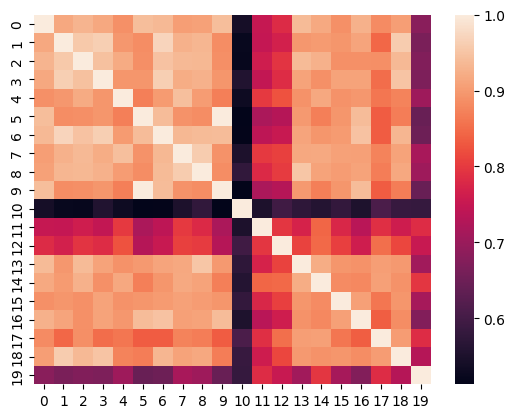

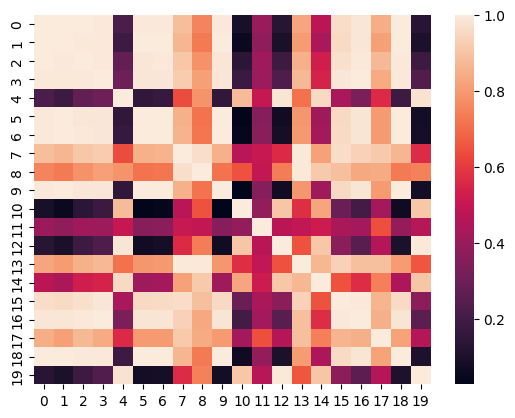

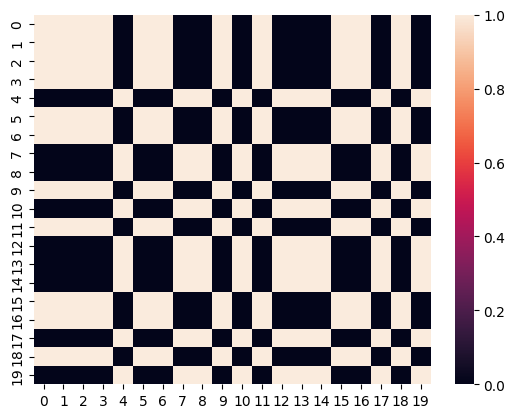

corr(gin, wl) = 0.6561219538474895


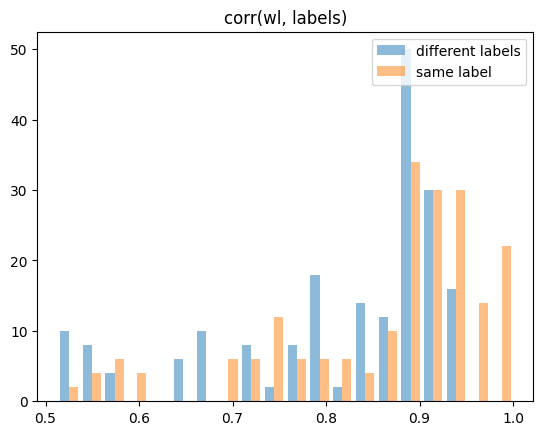

corr(wl, labels) = 0.20386629791552918


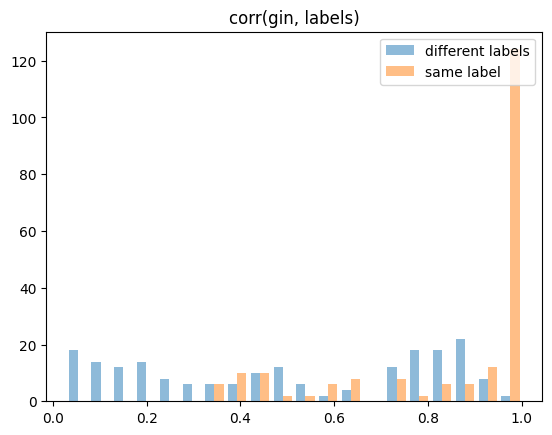

corr(gin, labels) = 0.5574090361353199


In [83]:
for dataset_name, dataset in all_datasets:
    print("======", dataset_name, "======")
    
#     graph_sims = dict_graph_sims[dataset_name].numpy()
#     seaborn.heatmap(graph_sims)
#     plt.show()
    
    kernel = dict_wl_kernels[dataset_name]
    seaborn.heatmap(kernel)
    plt.show()

    gin_sims = dict_gin_sims[dataset_name].numpy()
    seaborn.heatmap(gin_sims)
    plt.show()
    
    matching_labels = dict_matching_labels[dataset_name].numpy()
    seaborn.heatmap(matching_labels)
    plt.show()
    
#     print('corr(lcs, wl) =', np.corrcoef(graph_sims.flatten(), kernel.flatten())[0, 1])

#     plt.hist([graph_sims.flatten()[matching_labels.flatten() == 0], graph_sims.flatten()[matching_labels.flatten() == 1]], bins=20, alpha=0.5, label=['different labels', 'same label'])
#     plt.title('corr(lcs, labels)')
#     plt.legend(loc='upper right')
#     plt.show()
#     print('corr(lcs, labels) = ', np.corrcoef(graph_sims.flatten(), matching_labels.flatten())[0, 1])

    print('corr(gin, wl) =', np.corrcoef(gin_sims.flatten(), kernel.flatten())[0, 1])

    plt.hist([kernel.flatten()[matching_labels.flatten() == 0], kernel.flatten()[matching_labels.flatten() == 1]], bins=20, alpha=0.5, label=['different labels', 'same label'])
    plt.title('corr(wl, labels)')
    plt.legend(loc='upper right')
    plt.show()
    print('corr(wl, labels) =', np.corrcoef(kernel.flatten(), matching_labels.flatten())[0, 1])
    
    plt.hist([gin_sims.flatten()[matching_labels.flatten() == 0], gin_sims.flatten()[matching_labels.flatten() == 1]], bins=20, alpha=0.5, label=['different labels', 'same label'])
    plt.title('corr(gin, labels)')
    plt.legend(loc='upper right')
    plt.show()
    print('corr(gin, labels) =', np.corrcoef(gin_sims.flatten(), matching_labels.flatten())[0, 1])
    
    break

In [ ]:
# def partition_ged(dataset, dist):
#     partitions = [] # Found partitions
#     for G_idx, G_torch in enumerate(dataset): # Loop over each element
#         G_nx = to_networkx(G_torch)
#         found = False # Note it is not yet part of a know partition
#         for p in partitions:
#             for _, p_G in p:
#                 eq = False
#                 for v in nx.optimize_graph_edit_distance(G_nx, p_G, upper_bound=dist):
#                     if v is not None:
#                         eq = True
#                         break
#                 if not eq:
#                     break
#             if eq:
#                 p.append((G_idx, G_nx))
#                 found = True
#         if not found: # Make a new partition for it.
#             partitions.append([(G_idx, G_nx)])
#     return partitions